## **Trabajo Práctico Final - Proyecto de Machine Learning para Logística Aérea: Optimización de tiempos de transporte aéreo**

# **Grupo V - Integrantes:**

**- GRACIELA ARIAS**

**- SOFIA TSCHOPP**

---



# **Introducción y Objetivos**
Este proyecto aborda la alta incertidumbre en el Tiempo de Tránsito Aéreo, el principal cuello de botella logístico. Desarrollamos un Modelo de Regresión de Machine Learning para identificar los factores operacionales ocultos (carriers, rutas) que causan esta variabilidad. Nuestro objetivo es reducir el Error (RMSE) a no más de 2 días, logrando un ETA significativamente más preciso.

# **Comprensión del Negocio y Alcance**
La dispersión actual del Tiempo de tránsito aéreo impacta negativamente la planificación y la satisfacción del cliente. El modelo usa datos reales de la importación de insumos mineros para generar un ETA confiable. La implementación final permitirá la gestión proactiva de proveedores y una planificación logística más eficiente al proveer fechas exactas.

**IMPORTACIÓN DE LIBRERÍAS**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
sns.set()
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr


**IMPORTACIÓN DE DATASET**

In [2]:
# Importamos el dataset desde github
# Agregamos 'sep=;' para indicar que las columnas están separadas por punto y coma.

RAW_URL = 'https://raw.githubusercontent.com/sofiayt2/Trabajo_Final_Grupo_V/refs/heads/main/DATASET_AEREOS.csv'

df = pd.read_csv(RAW_URL, sep=';')

**INSPECCIÓN Y ANÁLISIS DE DATOS INICIAL**

In [3]:
# DIMENSIONES DEL DATAFRAME
print(df.shape)

(2640, 17)


In [4]:
# PRIMERAS 5 FILAS
print(df.head())

  Waybill (Reference)  MOT   Type of Service Forwarded Carrier  \
0           A12345678  AIR  STANDARD ECONOMY    TRANSIT XPRESS   
1           A12345679  AIR  STANDARD ECONOMY    TRANSIT XPRESS   
2           A12345680  AIR  STANDARD ECONOMY    TRANSIT XPRESS   
3           A12345681  AIR  STANDARD ECONOMY    TRANSIT XPRESS   
4           A12345682  AIR  STANDARD ECONOMY    TRANSIT XPRESS   

   Total Invoice Value (USD)   Total Packages Total Gross Weight (Kilograms)  \
0                 $ 9.058,47                1                         142,00   
1                $ 17.776,00                4                        1150,00   
2                $ 12.016,20                2                        1870,00   
3                 $ 5.471,74                3                        2445,00   
4                    $ 19,99                1                           4,17   

  Port Departure   Country  Port Arrival Target Date Carrier SLA Pickup Date  \
0        SVEDALA    SUECIA  BUENOS AIRES  

In [5]:
# INFORMACIÓN Y TIPOS DE DATOS
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2640 entries, 0 to 2639
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Waybill (Reference)             2640 non-null   object
 1   MOT                             2640 non-null   object
 2   Type of Service                 2640 non-null   object
 3   Forwarded Carrier               2640 non-null   object
 4    Total Invoice Value (USD)      2640 non-null   object
 5   Total Packages                  2640 non-null   int64 
 6   Total Gross Weight (Kilograms)  2640 non-null   object
 7   Port Departure                  2640 non-null   object
 8   Country                         2640 non-null   object
 9   Port Arrival                    2640 non-null   object
 10  Target Date                     2627 non-null   object
 11  Carrier SLA                     2637 non-null   object
 12  Pickup Date                     2640 non-null   

In [6]:
# LISTA DE COLUMNAS
print(df.columns.tolist())

['Waybill (Reference)', 'MOT', 'Type of Service', 'Forwarded Carrier', ' Total Invoice Value (USD) ', 'Total Packages', 'Total Gross Weight (Kilograms)', 'Port Departure', 'Country', 'Port Arrival', 'Target Date', 'Carrier SLA', 'Pickup Date', 'Estimated time of delivery', 'Actual time of delivery', 'Estimated time of arrival', 'Actual time of arrival']


**LIMPIEZA DE DATOS INICIAL**

In [7]:
# Se normalizan nombres de columnas quitando espacios y caracteres innecesarios:

df.columns = (
    df.columns.str.strip()
    .str.lower()
    .str.replace(' ', '_')
    .str.replace('(', '', regex=False)
    .str.replace(')', '', regex=False)
    .str.replace('.', '', regex=False)
    .str.replace('time_of_', '')
    .str.replace('-', '_')
    .str.replace('__', '_', regex=False)
)

In [8]:
# Limpieza y conversión de columnas numéricas:

# - Se quita puntuación y otros caracteres que puedan afectar los resultados (Ej. Signo "$", punto de miles)
# - Reemplazo de coma decimal por punto decimal.
# - Reemplazo de espacios vacíos y guiones por NaN.
# - Convertir a número. Si encuentra texto o un valor inválido, lo cambia por un valor faltante (NaN).

def clean_numeric_column(series, is_invoice=False):
    series = series.astype(str).str.strip()
    if is_invoice:
        series = series.str.replace('$', '', regex=False).str.replace('.', '', regex=False).str.replace(',', '.', regex=False)
        series = series.replace('', np.nan).replace('-', np.nan)
    else:
        series = series.str.replace(',', '.', regex=False)

    return pd.to_numeric(series, errors='coerce')

df['total_invoice_value_usd'] = clean_numeric_column(df['total_invoice_value_usd'], is_invoice=True)
df['total_gross_weight_kilograms'] = clean_numeric_column(df['total_gross_weight_kilograms'])


In [9]:
# Limpieza de Fechas:

# - Se le da formato uniforme a todas las celdas que contengan una fecha
# - Se corrigen los errores de formato del excel que pueden hacer que la informacion sea invalida

from datetime import datetime, timedelta
OLE_TIME_ZERO = datetime(1899, 12, 30)
def clean_date_column(series):
    def convert_ole_date(value):
        if pd.notna(value) and isinstance(value, (int, float)):
            if value >= 60: value -= 1
            return OLE_TIME_ZERO + timedelta(days=value)
        return value

    series = series.apply(convert_ole_date)
    series = pd.to_datetime(series, dayfirst=True, errors='coerce')
    return series

date_cols = [col for col in df.columns if 'date' in col or 'arrival' in col or 'delivery' in col or 'sla' in col]
for col in date_cols:
    df[col] = clean_date_column(df[col])

In [10]:
# Eliminación de Columnas Innecesarias (Por ejemplo, puerto de llegada Buenos Aires o tipo de transporte Aéreo ya que siempre se mantienen constantes).

columns_to_drop = [
    'waybill_reference',
    'mot',
    'port_arrival',
    'total_invoice_value_usd',
    'total_packages',
]

df = df.drop(columns=columns_to_drop, errors='ignore')

In [11]:
# COMPROBACIÓN DE VALORES FALTANTES

print(df.isnull().sum())

type_of_service                   0
forwarded_carrier                 0
total_gross_weight_kilograms      0
port_departure                    0
country                           0
target_date                     699
carrier_sla                     699
pickup_date                       0
estimated_delivery                1
actual_delivery                   0
estimated_arrival                 7
actual_arrival                    0
dtype: int64


# **FEATURE ENGINEERING: CÁLCULO DE TIEMPOS DE TRÁNSITO**

In [12]:
# Cálculo de las variables necesarias:

df['transit_time_days_real'] = (df['actual_arrival'] - df['pickup_date']).dt.total_seconds() / (24 * 3600)

df['transit_time_days_estimated'] = (df['estimated_arrival'] - df['pickup_date']).dt.total_seconds() / (24 * 3600)

df['arrival_performance_days'] = (df['actual_arrival'] - df['estimated_arrival']).dt.total_seconds() / (24 * 3600)

df_model = df.dropna(subset=['transit_time_days_real']).copy()
rows_dropped = len(df) - len(df_model)

df_model.info()

# Guardado de la variable global
globals()['df_model'] = df_model

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2640 entries, 0 to 2639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   type_of_service               2640 non-null   object        
 1   forwarded_carrier             2640 non-null   object        
 2   total_gross_weight_kilograms  2640 non-null   float64       
 3   port_departure                2640 non-null   object        
 4   country                       2640 non-null   object        
 5   target_date                   1941 non-null   datetime64[ns]
 6   carrier_sla                   1941 non-null   datetime64[ns]
 7   pickup_date                   2640 non-null   datetime64[ns]
 8   estimated_delivery            2639 non-null   datetime64[ns]
 9   actual_delivery               2640 non-null   datetime64[ns]
 10  estimated_arrival             2633 non-null   datetime64[ns]
 11  actual_arrival                

# **ANÁLISIS UNIVARIADO**

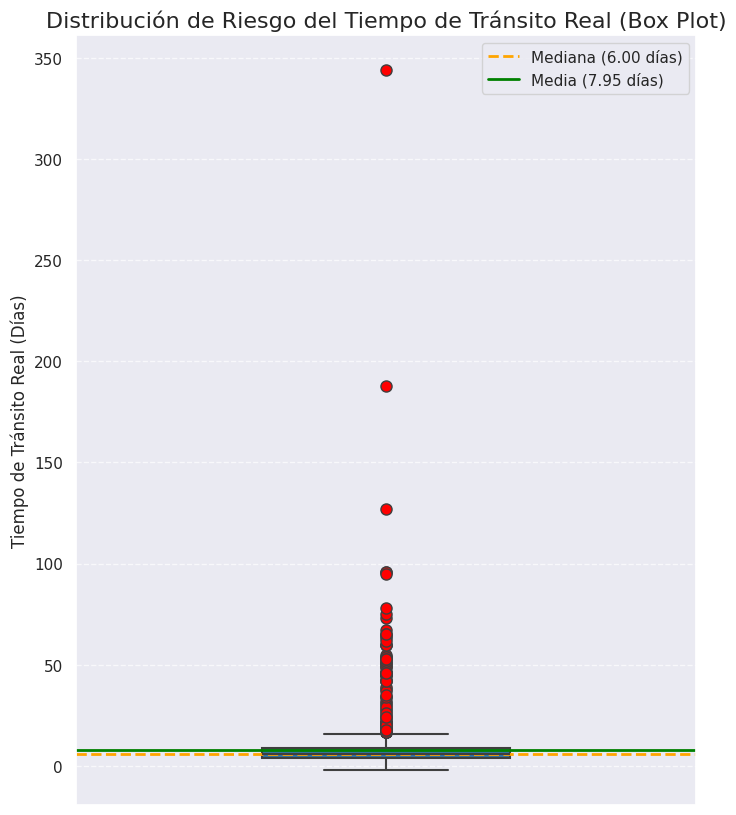

In [13]:
# ANÁLISIS UNIVARIADO

# BOXPLOT para visualizar la Mediana, los Cuartiles y los Outliers.

plt.figure(figsize=(8, 10))
sns.boxplot(y=df_model['transit_time_days_real'], color='#1f77b4', width=0.4, linewidth=1.5, flierprops={'marker': 'o', 'markerfacecolor': 'red', 'markersize': 8, 'linestyle': 'none'})

median_val = df_model['transit_time_days_real'].median()
mean_val = df_model['transit_time_days_real'].mean()

plt.axhline(median_val, color='orange', linestyle='--', linewidth=2, label=f'Mediana ({median_val:.2f} días)')
plt.axhline(mean_val, color='green', linestyle='-', linewidth=2, label=f'Media ({mean_val:.2f} días)')

plt.title('Distribución de Riesgo del Tiempo de Tránsito Real (Box Plot)', fontsize=16)
plt.ylabel('Tiempo de Tránsito Real (Días)', fontsize=12)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [14]:
# ELIMINACIÓN DE OUTLIERS, ERRORES O VALORES ATÍPICOS

# Calculamos el rango intercuartílico (IQR)
Q1 = df_model['transit_time_days_real'].quantile(0.25)
Q3 = df_model['transit_time_days_real'].quantile(0.75)
IQR = Q3 - Q1

# Definimos los límites para detectar outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Registrar el número de filas antes de la limpieza
initial_rows = len(df_model)

# Filtramos el DataFrame, manteniendo solo los valores dentro de los límites
df_model_clean = df_model[
    (df_model['transit_time_days_real'] >= lower_bound) &
    (df_model['transit_time_days_real'] <= upper_bound)
].copy()

# Creamos nuevo dataframe sin outliers
removed_outliers = initial_rows - len(df_model_clean)
percentage_removed = (removed_outliers / initial_rows) * 100

# Reemplazamos la variable df_model con la versión limpia para los modelos subsiguientes
globals()['df_model'] = df_model_clean

# **ANÁLISIS BIVARIADO**

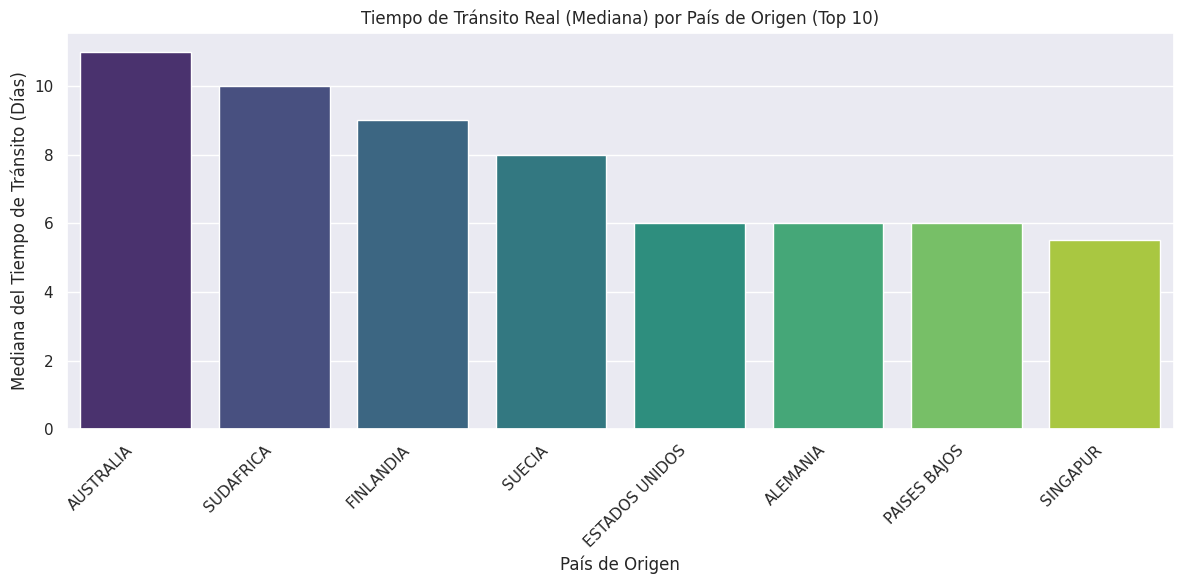

In [15]:
# Bivariado por País (Mediana)
top_countries = df_model['country'].value_counts().nlargest(10).index
df_top_countries = df_model[df_model['country'].isin(top_countries)]

country_mean_time = df_top_countries.groupby('country')['transit_time_days_real'].median().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=country_mean_time.index, y=country_mean_time.values, palette="viridis")
plt.title('Tiempo de Tránsito Real (Mediana) por País de Origen (Top 10)')
plt.xlabel('País de Origen')
plt.ylabel('Mediana del Tiempo de Tránsito (Días)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


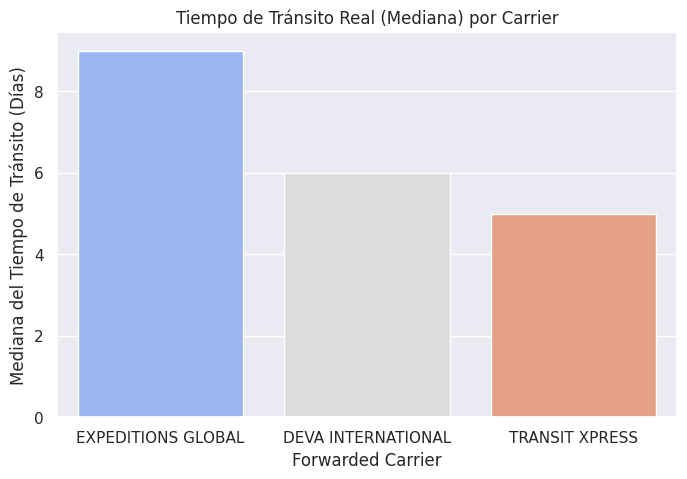

In [16]:
# Gráfico de Barras de Tiempo de Tránsito Real por Carrier (Mediana)

carrier_mean_time = df_model.groupby('forwarded_carrier')['transit_time_days_real'].median().sort_values(ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x=carrier_mean_time.index, y=carrier_mean_time.values, palette="coolwarm")
plt.title('Tiempo de Tránsito Real (Mediana) por Carrier')
plt.xlabel('Forwarded Carrier')
plt.ylabel('Mediana del Tiempo de Tránsito (Días)')
plt.show()

# **PREPARACIÓN FINAL DE DATASET PARA APLICACIÓN DE MODELOS DE REGRESIÓN**

In [17]:
print(df_model.columns.tolist())

['type_of_service', 'forwarded_carrier', 'total_gross_weight_kilograms', 'port_departure', 'country', 'target_date', 'carrier_sla', 'pickup_date', 'estimated_delivery', 'actual_delivery', 'estimated_arrival', 'actual_arrival', 'transit_time_days_real', 'transit_time_days_estimated', 'arrival_performance_days']


In [18]:
# Se intercambian valores faltantes por la mediana.
# Se hace una conversion logaritmica del peso del envio para tratar los outliers
# Se eliminan columnas redundantes
# Se eliminan columnas con fechas que no indiquen una cantidad de dias.
# Se modifican columnas con datos categoricos para facilitar su uso en los modelos

cols_to_impute_median = ['total_gross_weight_kilograms']
for col in cols_to_impute_median:
    if col in df_model.columns and df_model[col].isnull().any():
        df_model[col] = df_model[col].fillna(df_model[col].median())

df_model['log_weight'] = np.log1p(df_model['total_gross_weight_kilograms'])

df_model = df_model.drop(columns=['total_gross_weight_kilograms'], errors='ignore')

categorical_cols = ['country', 'forwarded_carrier', 'port_departure', 'type_of_service']
df_model = pd.get_dummies(df_model, columns=categorical_cols, drop_first=True)

date_cols_to_drop = [
    col for col in df_model.columns
    if any(date_part in col for date_part in ['date', 'arrival', 'delivery', 'sla'])
    and 'days' not in col
]
df_model = df_model.drop(columns=date_cols_to_drop, errors='ignore')

In [19]:
# DIVISIÓN DE DATOS:

# - Se define variable Target "Y"
# - Se excluyen las columnas con el target y la metrica de rendimiento que se va a usar
# - Se hace un ultimo chequeo por valores faltantes para evitar errores. Se reemplazan por la mediana.

Y = df_model['transit_time_days_real']
X = df_model.drop(columns=['transit_time_days_real', 'arrival_performance_days'])

for col in X.columns:
    if X[col].dtype != object and X[col].isnull().any():
        X[col] = X[col].fillna(X[col].median())

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# **MODELOS**

# **1. REGRESIÓN LINEAL**

In [20]:
lr_model = LinearRegression()
lr_model.fit(X_train, Y_train)
lr_predictions = lr_model.predict(X_test)
lr_rmse = np.sqrt(mean_squared_error(Y_test, lr_predictions))
lr_r2_final = r2_score(Y_test, lr_predictions) # Calculate and store R²

print("--- RESULTADOS MODELO 1: REGRESIÓN LINEAL (BASELINE) ---")
print(f"RMSE (Error Promedio): {lr_rmse:.2f} días")
print(f"R²: {lr_r2_final:.3f}") # Print R²

--- RESULTADOS MODELO 1: REGRESIÓN LINEAL (BASELINE) ---
RMSE (Error Promedio): 1.88 días
R²: 0.625


# **2. RANDOM FOREST REGRESSOR**

In [21]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, Y_train)
rf_predictions = rf_model.predict(X_test)
rf_rmse = np.sqrt(mean_squared_error(Y_test, rf_predictions))
rf_r2_final = r2_score(Y_test, rf_predictions) # Calculate and store R²


print("--- RESULTADOS MODELO 2: RANDOM FOREST REGRESSOR ---")
print(f"RMSE (Error Promedio): {rf_rmse:.2f} días")
print(f"R²: {rf_r2_final:.3f}") # Print R²

--- RESULTADOS MODELO 2: RANDOM FOREST REGRESSOR ---
RMSE (Error Promedio): 1.96 días
R²: 0.594


# **3. MODELO XGBOOST REGRESSOR**

In [22]:
# Modelado
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror', # Función de pérdida para regresión
    n_estimators=100,             # Número de árboles
    learning_rate=0.1,            # Tasa de aprendizaje
    max_depth=5,                  # Profundidad máxima del árbol
    random_state=42,
    n_jobs=-1
)

# Entrenamiento
xgb_model.fit(X_train, Y_train)

# Predicción en el conjunto de prueba
xgb_predictions = xgb_model.predict(X_test)

# Evaluación
xgb_mse = mean_squared_error(Y_test, xgb_predictions)
xgb_rmse = np.sqrt(xgb_mse)
xgb_r2 = r2_score(Y_test, xgb_predictions)

print("--- RESULTADOS MODELO 3: XGBOOST REGRESSOR ---")
print(f"XGBoost RMSE (Días): {xgb_rmse:.2f}")
print(f"XGBoost R²: {xgb_r2:.3f}")

# Guardar la variable para la comparativa final
xgb_rmse_final = xgb_rmse
xgb_r2_final = xgb_r2

--- RESULTADOS MODELO 3: XGBOOST REGRESSOR ---
XGBoost RMSE (Días): 1.80
XGBoost R²: 0.656


# **4. MODELO LSTM**

In [23]:
# En este modelo volvemos a realizar varias comprobaciones y definir algunas variables.
# El objetivo es poder ejecutar el codigo exitosamente y sin errores que hayan sido arrastrados de ejecuciones anteriores:

date_cols = [
    'actual_delivery',
    'estimated_delivery',
    'pickup_date',
    'target_date',
    'carrier_sla',
    'estimated_arrival'
]

for col in date_cols:
    df[col] = pd.to_datetime(df[col], dayfirst=True, errors='coerce')

df['transit_time_days_real'] = (df['actual_delivery'] - df['pickup_date']).dt.days

relevant_cols_lstm = date_cols + ['transit_time_days_real']
df_model_lstm = df.dropna(subset=relevant_cols_lstm).copy()

base_date = df_model_lstm['pickup_date'].min()

df_model_lstm['transit_time_days_estimated'] = (df_model_lstm['estimated_delivery'] - df_model_lstm['pickup_date']).dt.days
df_model_lstm['target_date_days'] = (df_model_lstm['target_date'] - base_date).dt.days
df_model_lstm['carrier_sla_days'] = (df_model_lstm['carrier_sla'] - base_date).dt.days
df_model_lstm['estimated_arrival_days'] = (df_model_lstm['estimated_arrival'] - base_date).dt.days # Nueva variable de días

# DEFINICIÓN DE VARIABLES Y ESCALADO (Nombres Corregidos)


time_features = [
    'transit_time_days_estimated',
    'carrier_sla_days',
    'target_date_days',
    'estimated_arrival_days',
]
TARGET = 'transit_time_days_real'
N_TIMESTEPS = 4

X = df_model_lstm[time_features].values
Y = df_model_lstm[TARGET].values.reshape(-1, 1).astype(float)


scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_Y = MinMaxScaler(feature_range=(0, 1))


X_scaled = scaler_X.fit_transform(X)
Y_scaled = scaler_Y.fit_transform(Y)



# Remodelar X a 3D
X_3D = X_scaled.reshape(X_scaled.shape[0], N_TIMESTEPS, 1)

# Dividir datos en entrenamiento y prueba
X_train, X_test, Y_train, Y_test = train_test_split(
    X_3D,
    Y_scaled,
    test_size=0.2,
    shuffle=False,
    random_state=42
)


#  CONSTRUCCIÓN Y ENTRENAMIENTO DEL MODELO LSTM

lstm_model = Sequential([
    LSTM(50, activation='relu', input_shape=(N_TIMESTEPS, 1), return_sequences=True),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

lstm_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=[RootMeanSquaredError()]
)

history = lstm_model.fit(
    X_train,
    Y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    verbose=0
)


# PREDICCIÓN Y EVALUACIÓN

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
Y_pred_scaled = lstm_model.predict(X_test, verbose=0)

Y_pred_real = scaler_Y.inverse_transform(Y_pred_scaled)
Y_test_real = scaler_Y.inverse_transform(Y_test)

mse = mean_squared_error(Y_test_real, Y_pred_real)
rmse = np.sqrt(mse)
mae = mean_absolute_error(Y_test_real, Y_pred_real)
r2 = r2_score(Y_test_real, Y_pred_real)


print("--- RESULTADOS MODELO 4: MODELO LSTM ---")
print(f"Raíz del Error Cuadrático Medio (RMSE): {rmse:.4f} días")
print(f"Error Absoluto Medio (MAE): {mae:.4f} días")
print(f"Coeficiente de Determinación (R2 Score): {r2:.4f}")

--- RESULTADOS MODELO 4: MODELO LSTM ---
Raíz del Error Cuadrático Medio (RMSE): 15.8637 días
Error Absoluto Medio (MAE): 1.5632 días
Coeficiente de Determinación (R2 Score): 0.1657


# **CUADRO COMPARATIVO FINAL DE MODELOS**

In [25]:

print("---  ANÁLISIS COMPARATIVO DE MODELOS  ---")
print("RMSE de Benchmark (Desviación Estándar Histórica): 10.37 días")

lstm_rmse_days = rmse
lstm_r2_days = r2


data = {
    'Modelo': ['Benchmark (Naive)', 'Regresión Lineal', 'Random Forest', 'XGBoost Regressor', 'LSTM Regressor'],
    'RMSE (Días)': [10.37, lr_rmse, rf_rmse, xgb_rmse_final, lstm_rmse_days],
    'R² (Varianza Explicada)': [0.00, lr_r2_final, rf_r2_final, xgb_r2_final, lstm_r2_days],

}

df_comparativa = pd.DataFrame(data)


df_comparativa['RMSE (Días)'] = df_comparativa['RMSE (Días)'].round(2)
df_comparativa['R² (Varianza Explicada)'] = df_comparativa['R² (Varianza Explicada)'].round(3)


print("\n" + df_comparativa.to_markdown(index=False))


mejores_modelos = df_comparativa[df_comparativa['Modelo'] != 'Benchmark (Naive)']
mejor_modelo_nombre = mejores_modelos.loc[mejores_modelos['RMSE (Días)'].idxmin(), 'Modelo']
mejor_modelo_rmse = mejores_modelos.loc[mejores_modelos['RMSE (Días)'].idxmin(), 'RMSE (Días)']

---  ANÁLISIS COMPARATIVO DE MODELOS  ---
RMSE de Benchmark (Desviación Estándar Histórica): 10.37 días

| Modelo            |   RMSE (Días) |   R² (Varianza Explicada) |
|:------------------|--------------:|--------------------------:|
| Benchmark (Naive) |         10.37 |                     0     |
| Regresión Lineal  |          1.88 |                     0.625 |
| Random Forest     |          1.96 |                     0.594 |
| XGBoost Regressor |          1.8  |                     0.656 |
| LSTM Regressor    |         15.86 |                     0.166 |
